In [9]:
%matplotlib notebook

In [1]:
import numpy as np
import random
import itertools
from graph_tool import Graph, GraphView
from graph_tool.draw import graph_draw
from tqdm import tqdm

from matplotlib import pyplot as plt

from viz_helpers import lattice_node_pos
from minimum_steiner_tree import min_steiner_tree
from cascade_generator import si, observe_cascade
from eval_helpers import infection_precision_recall
from graph_helpers import remove_filters, load_graph_by_name

from inference import infer_infected_nodes
from query_selection import RandomQueryGenerator, OurQueryGenerator, PRQueryGenerator
from experiment import gen_input, one_round_experiment

In [2]:
g = load_graph_by_name('dolphin')

In [3]:
g

<GraphView object, undirected, with 62 vertices and 159 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f6fd411c128, at 0x7f6fd411c438>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f6fd411c128, at 0x7f6fbc3845f8>, False) at 0x7f6fd411c128>

In [4]:
if False:
    import graph_tool as gt
    pos = gt.draw.sfdp_layout(gv)
    vertex_text = g.new_vertex_property('string')
    for v in g.vertices():
        vertex_text[v] = str(v)
    gt.draw.graph_draw(gv, pos=pos, vertex_text=vertex_text)

In [18]:
scores = {
    'random': [],
    'pagerank': [],
    'ours': []
}

n_queries = 10

for i in tqdm(range(50)):
    obs, c = gen_input(g, stop_fraction=0.25)
    
    # for rand method
    gv = remove_filters(g)
    rand_gen = RandomQueryGenerator(gv, obs)
    score = one_round_experiment(gv, obs, c, rand_gen, 'random', n_queries)
    scores['random'].append(score)
    
    # for our method
    gv = remove_filters(g)
    our_gen = OurQueryGenerator(gv, obs, num_spt=100, num_stt=5,
                                method='entropy',
                                use_resample=False)
    score = one_round_experiment(gv, obs, c, our_gen, 'ours', n_queries)    
    scores['ours'].append(score)
    
    # for our pagerank
    gv = remove_filters(g)
    pr_gen = PRQueryGenerator(gv, obs)
    score = one_round_experiment(gv, obs, c, pr_gen, 'pagerank', n_queries)
    scores['pagerank'].append(score)


100%|██████████| 50/50 [19:28<00:00, 25.46s/it]


In [19]:
rand_mean_scores = np.mean(np.asarray(scores['random']), axis=0)
our_mean_scores = np.mean(np.asarray(scores['ours']), axis=0)
pr_mean_scores = np.mean(np.asarray(scores['pagerank']), axis=0)

[autoreload of experiment failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'profile' is not defined
]
[autoreload of core failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'profile' is not defined
]
[autoreload of graph_helpers failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'profile' is not defined
]


<IPython.core.display.Javascript object>


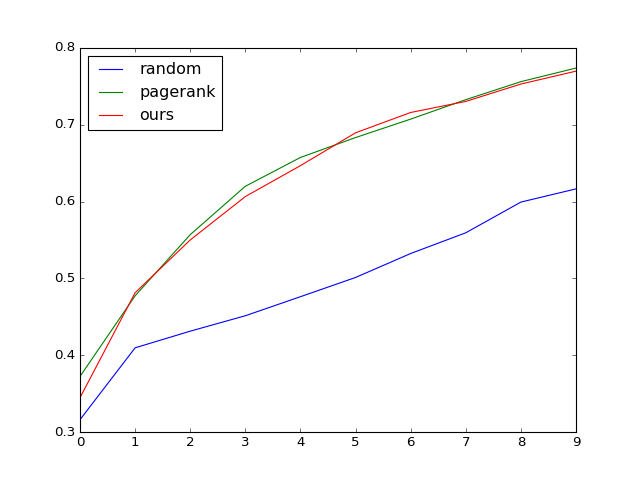

In [20]:
rand_prec, rand_rec = zip(*rand_mean_scores)
pr_prec, pr_rec = zip(*pr_mean_scores)
our_prec, our_rec = zip(*our_mean_scores)
fig = plt.figure()
fig.clf()
plt.plot(rand_prec)
plt.plot(pr_prec)
plt.plot(our_prec)
plt.legend(['random', 'pagerank', 'ours'], loc='upper left')

<IPython.core.display.Javascript object>


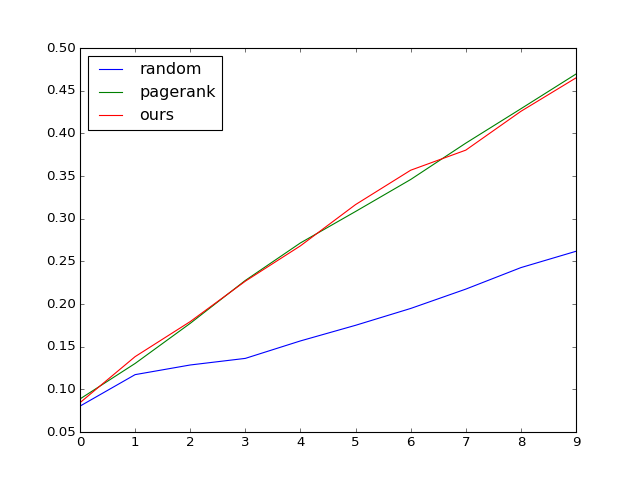

In [21]:
plt.figure()
plt.plot(rand_rec)
plt.plot(pr_rec)
plt.plot(our_rec)
plt.legend(['random', 'pagerank', 'ours'], loc='upper left')